In [17]:
#do the data things!
import numpy as np
import pandas as pd

#visualize
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text, create_engine

#my sql creds
import env
import os
import gen_wrangle1 as gw

In [18]:
sql_query = "select * from api_access"
directory = os.getcwd()
url_for_query = gw.get_db_url("logs")
filename = "api_access.csv"

In [19]:
gw.get_sql_data(sql_query, url_for_query, filename)

csv found and loaded


,Unnamed: 0,entry
0,0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...
...,...,...
13969,13969,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13970,13970,97.105.19.58 - - [17/Apr/2019:12:55:12 +0000] ...
13971,13971,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...
13972,13972,97.105.19.58 - - [17/Apr/2019:12:55:13 +0000] ...


In [20]:
df= pd.read_csv("api_access.csv")

In [21]:
df.head()

,Unnamed: 0,entry
0,0,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
1,1,97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] ...
2,2,97.105.19.58 - - [16/Apr/2019:19:34:44 +0000] ...
3,3,97.105.19.58 - - [16/Apr/2019:19:34:46 +0000] ...
4,4,97.105.19.58 - - [16/Apr/2019:19:34:48 +0000] ...


In [22]:
#accessing the first entry
df.entry[0]

'97.105.19.58 - - [16/Apr/2019:19:34:42 +0000] "GET /api/v1/sales?page=81 HTTP/1.1" 200 512495 "-" "python-requests/2.21.0"'

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  13974 non-null  int64 
 1   entry       13974 non-null  object
dtypes: int64(1), object(1)
memory usage: 218.5+ KB


In [24]:
#function to deal with parsing one entry in our log data by splitting on the spaces 
#this function works on one string
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).strip('"')
    return pd.Series(output)

In [25]:
#this function works on a dataframe to parse all entries by calling the function above
#.entry is the column name and .apply applies the function to each entry in the column
df=df.entry.apply(parse_log_entry)


In [26]:
df.head()

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,16/Apr/2019 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,16/Apr/2019 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,16/Apr/2019 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,16/Apr/2019 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0


### Detecting Anomalies in Discrete Variables
* get a count of the discrete var
* get the frequency 
* visualize it
* get the conditional probability

In [27]:
#count
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
68.201.219.223       21
24.26.242.9          21
52.87.230.102         2
35.175.171.137        2
70.121.214.34         2
54.172.14.223         1
52.91.30.150          1
54.145.52.184         1
35.174.209.2          1
45.23.250.16          1
3.92.201.136          1
52.90.165.200         1
34.229.70.250         1
3.88.129.158          1
34.207.64.242         1
Name: ip, dtype: int64

In [31]:
#for convenience create a new dataframe with the ip counts
ip_counts = df.ip.value_counts().reset_index().rename(columns={'index': 'ip', 'ip': 'ip_count'})


In [32]:
ip_counts.head()    

,ip,ip_count
0,97.105.19.58,11998
1,173.173.113.51,1059
2,72.181.113.170,613
3,72.181.105.81,246
4,68.201.219.223,21


In [34]:
#git the frequency of each ip address via the value_counts method with normalize=True
df.ip.value_counts(normalize=True)

97.105.19.58      0.858595
173.173.113.51    0.075784
72.181.113.170    0.043867
72.181.105.81     0.017604
68.201.219.223    0.001503
24.26.242.9       0.001503
52.87.230.102     0.000143
35.175.171.137    0.000143
70.121.214.34     0.000143
54.172.14.223     0.000072
52.91.30.150      0.000072
54.145.52.184     0.000072
35.174.209.2      0.000072
45.23.250.16      0.000072
3.92.201.136      0.000072
52.90.165.200     0.000072
34.229.70.250     0.000072
3.88.129.158      0.000072
34.207.64.242     0.000072
Name: ip, dtype: float64

In [35]:
#save the frequency of each ip address in a new dataframe
ip_freq = df.ip.value_counts(normalize=True).reset_index().rename(columns={'index': 'ip', 'ip': 'ip_percent'})

In [36]:
ip_freq.head()

,ip,ip_percent
0,97.105.19.58,0.858595
1,173.173.113.51,0.075784
2,72.181.113.170,0.043867
3,72.181.105.81,0.017604
4,68.201.219.223,0.001503


In [37]:
#merge the two dataframes together (inner join)
ip_df = ip_counts.merge(ip_freq, on='ip')

In [38]:
ip_df.head()

,ip,ip_count,ip_percent
0,97.105.19.58,11998,0.858595
1,173.173.113.51,1059,0.075784
2,72.181.113.170,613,0.043867
3,72.181.105.81,246,0.017604
4,68.201.219.223,21,0.001503


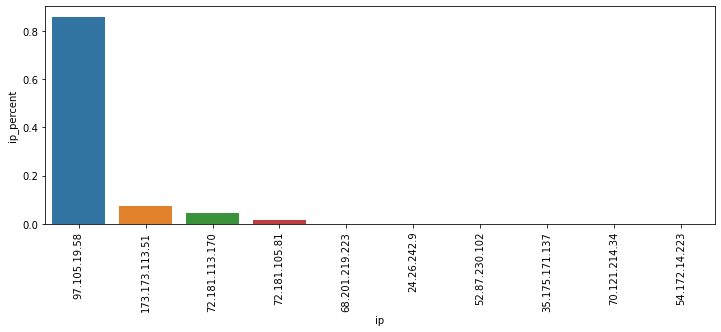

In [39]:
#visualize the percent of each ip address
plt.figure(figsize=(12, 4))
splot = sns.barplot(data=ip_df.head(10), x='ip', y='ip_percent')
splot.set_xticklabels(splot.get_xticklabels(), rotation=90)
plt.show()

### Conditional probability

* what is the probability of event A happening given that event B has happened?
* aka: the probability of both event A and event B happening divided by the probability of only B happening
* in this case what is the probability of a specific status code given an IP address?

In [40]:
#get the count for ip and status code
df.groupby(["ip", "status_code"]).size()

ip              status_code
173.173.113.51  200             1059
24.26.242.9     200               21
3.88.129.158    200                1
3.92.201.136    200                1
34.207.64.242   200                1
34.229.70.250   200                1
35.174.209.2    200                1
35.175.171.137  200                2
45.23.250.16    200                1
52.87.230.102   200                2
52.90.165.200   200                1
52.91.30.150    200                1
54.145.52.184   200                1
54.172.14.223   200                1
68.201.219.223  200               21
70.121.214.34   200                2
72.181.105.81   200              246
72.181.113.170  200              611
                499                2
97.105.19.58    200            11984
                499               14
dtype: int64

In [41]:
#create a new dataframe with the the probability of each ip address getting a status code
prob_a_and_b = df.groupby(["ip", "status_code"]).size() / len(df)

In [42]:
prob_a_and_b.head()

ip              status_code
173.173.113.51  200            0.075784
24.26.242.9     200            0.001503
3.88.129.158    200            0.000072
3.92.201.136    200            0.000072
34.207.64.242   200            0.000072
dtype: float64

In [43]:
#probability of an ip 
prob_b = df.groupby("ip").size() / len(df)
prob_b.head()

ip
173.173.113.51    0.075784
24.26.242.9       0.001503
3.88.129.158      0.000072
3.92.201.136      0.000072
34.207.64.242     0.000072
dtype: float64

In [52]:
# Given a particular ip, what is probability of a certain status code and save it in a new dataframe
status_given_ip = df.groupby('ip').status_code.value_counts(normalize=True).rename('prob').reset_index()

In [53]:
status_given_ip.head()

,ip,status_code,prob
0,173.173.113.51,200,1.0
1,24.26.242.9,200,1.0
2,3.88.129.158,200,1.0
3,3.92.201.136,200,1.0
4,34.207.64.242,200,1.0


In [54]:
#look for the ip were the prob is less than 100% as those ips have multiple status codes
status_given_ip[status_given_ip.prob < 1]

,ip,status_code,prob
17,72.181.113.170,200,0.996737
18,72.181.113.170,499,0.003263
19,97.105.19.58,200,0.998833
20,97.105.19.58,499,0.001167


In [56]:
#find the status codes other than 200 as those could be anomalies
status_given_ip[status_given_ip.status_code != '200']

,ip,status_code,prob
18,72.181.113.170,499,0.003263
20,97.105.19.58,499,0.001167
